# Neural Networks for Data Science Applications
## End-of-term homework: Advanced transfer learning

**Name**: *\<insert your name here\>*

**Matricola**: *\<insert your ID here\>*

> ✍ Upload the completed notebook **at least two days** before your expected exam's date on the Google Classroom page. For example, for the **January 12th** session, you should upload it by **January 9th, 23:59 Rome time**.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Instructions

1. The homework is divided into two exercises. The first one (**10 points**) is mandatory for everyone. The second one (**5 points**) is mandatory only if you have not submitted the first homework or if you want to increase the mark.
2. If you score well on the project but poorly on the oral, the grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

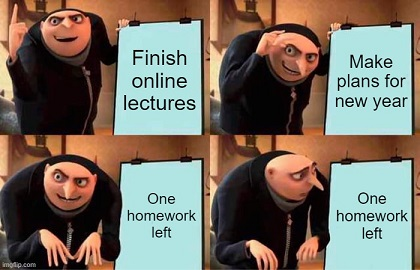

## Warmup: Data loading

**For this part, select an interesting dataset.**

*   This is similar to [Exercise 1 from the mid-term homework](https://colab.research.google.com/drive/1oDbshJeY62Id1O5pbsCrNFX9PdSY1ITP?usp=sharing), which you can check for completeness.
*   You should use a **different dataset** from the first homework, possibly of higher complexity.
*   Any data type (tabular, images, videos, audio, time-series, graphs, ...) is okay.

✍ **DESCRIPTION OF THE CODE**

*Provide a SHORT description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [3]:
# TODO: Insert all code here.
!pip install datasets
from datasets import load_dataset
# Load the dataset from Hugging Face
dataset = load_dataset("zeroshot/twitter-financial-news-topic")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [4]:
# Explore the dataset structure
train_dataset = dataset["train"]
validation_dataset = dataset["validation"]

In [5]:
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification, DistilBertConfig
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Assuming `train_dataset` is your TensorFlow dataset
# Extract labels from the dataset
labels = []
for _, label in train_dataset.unbatch().take(-1):
    labels.append(label.numpy())
labels = np.array(labels)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Now you can use `class_weight_dict` in the training process


In [ ]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dense, Dropout

class LearningRateFinder(Callback):
    def __init__(self, start_lr, end_lr, num_iters):
        super(LearningRateFinder, self).__init__()
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_iters = num_iters
        self.lr_mult = (end_lr / start_lr) ** (1 / num_iters)
        self.lrs = []
        self.losses = []

    def on_train_begin(self, logs=None):
        self.best_loss = float('inf')
        tf.keras.backend.set_value(self.model.optimizer.lr, self.start_lr)

    def on_batch_end(self, batch, logs=None):
        lr = tf.keras.backend.get_value(self.model.optimizer.lr)
        loss = logs['loss']
        self.lrs.append(lr)
        self.losses.append(loss)

        if batch > 0 and loss > 4 * self.best_loss:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        lr *= self.lr_mult
        tf.keras.backend.set_value(self.model.optimizer.lr, lr)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

class LoRADense(tf.keras.layers.Layer):
    def __init__(self, units, rank=16, dropout_rate=0.1, l2_lambda=0.01, **kwargs):
        super(LoRADense, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_lambda),
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.W1 = self.add_weight(shape=(input_shape[-1], self.rank),
                                  initializer='random_normal',
                                  trainable=True)
        self.W2 = self.add_weight(shape=(self.rank, self.units),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs, training=False):
        original_output = tf.matmul(inputs, self.W) + self.b
        lora_update = tf.matmul(inputs, self.W1)
        if training:
            lora_update = Dropout(self.dropout_rate)(lora_update)
        lora_update = tf.matmul(lora_update, self.W2)
        return original_output + lora_update

class FinBERTLoRAModel(tf.keras.Model):
    def __init__(self, num_classes, rank=16, num_lora_layers=2, unfreeze_layers=2, **kwargs):
        super(FinBERTLoRAModel, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone')
        self.classifier = Dense(num_classes)
        # Set all layers to non-trainable initially
        self.bert.trainable = False

        # Unfreeze the specified layers of BERT
        for layer in self.bert.bert.encoder.layer[-unfreeze_layers:]:
            layer.trainable = True

        # Initialize multiple LoRA layers
        self.lora_layers = []
        for _ in range(num_lora_layers):
            lora_layer = LoRADense(self.bert.config.hidden_size, rank=rank)
            self.lora_layers.append(lora_layer)

        self.dropout = Dropout(0.1)
        self.classifier = Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        bert_output = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        lora_output = pooled_output
        for lora_layer in self.lora_layers:
            lora_output = lora_layer(lora_output, training=training)
            lora_output = self.dropout(lora_output, training=training)

        final_output = self.classifier(lora_output)
        return final_output


# Instantiate the model
num_classes = 20
lora_rank = 16
num_lora_layers = 2  # Number of LoRA layers
unfreeze_layers = 3
# Instantiate and compile the model as before
model = FinBERTLoRAModel(num_classes=num_classes, rank=lora_rank, num_lora_layers=num_lora_layers, unfreeze_layers=unfreeze_layers)


def prepare_dataset(dataset):
    tokenized_inputs = tokenizer(dataset["text"], padding=True, truncation=True, max_length=128, return_tensors="tf")
    labels = tf.convert_to_tensor(dataset["label"])
    return tf.data.Dataset.from_tensor_slices(({"input_ids": tokenized_inputs["input_ids"],
                                                "attention_mask": tokenized_inputs["attention_mask"]},
                                               labels))


# Prepare train and validation datasets
train_dataset = prepare_dataset(dataset['train'])
validation_dataset = prepare_dataset(dataset['validation'])

train_dataset = train_dataset.shuffle(10000).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#    initial_learning_rate=5e-5,
#    decay_steps=10000,
#    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lr_finder = LearningRateFinder(start_lr=1e-6, end_lr=1, num_iters=100)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    class_weight=class_weight_dict
)




Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/100
531/531 [==============================] - 200s 350ms/step - loss: 16.5141 - accuracy: 0.3471 - val_loss: 15.0102 - val_accuracy: 0.4673
Epoch 2/100
531/531 [==============================] - 187s 352ms/step - loss: 13.8668 - accuracy: 0.4969 - val_loss: 12.7159 - val_accuracy: 0.5839
Epoch 3/100
531/531 [==============================] - 188s 354ms/step - loss: 11.8094 - accuracy: 0.5424 - val_loss: 10.8711 - val_accuracy: 0.5951
Epoch 4/100
531/531 [==============================] - 188s 354ms/step - loss: 10.0546 - accuracy: 0.5663 - val_loss: 9.3230 - val_accuracy: 0.6012
Epoch 5/100
531/531 [==============================] - 195s 367ms/step - loss: 8.5616 - accuracy: 0.5769 - val_loss: 7.9610 - val_accuracy: 0.6065
Epoch 6/100
531/531 [==============================] - 189s 356ms/step - loss: 7.2941 - accuracy: 0.5877 - val_loss: 6.7955 - val_accuracy: 0.6179
Epoch 7/100
531/531 [==============================] - 190s 357ms/step - loss: 6.2553 - accuracy: 0.5952 - val_

In [21]:
model.summary()

Model: "fin_bert_lo_ra_model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_5 (TFBertMod  multiple                  109751808 
 el)                                                             
                                                                 
 lo_ra_dense_6 (LoRADense)   multiple                  615168    
                                                                 
 lo_ra_dense_7 (LoRADense)   multiple                  615168    
                                                                 
 dropout_228 (Dropout)       multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  15380     
                                                                 
Total params: 110997524 (423.42 MB)
Trainable params: 1245716 (4.75 MB)
Non-trainable params: 109751808 (418.6

In [25]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Dense, Dropout

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone')

class LoRADense(tf.keras.layers.Layer):
    def __init__(self, units, rank=16, dropout_rate=0.1, l2_lambda=0.01, **kwargs):
        super(LoRADense, self).__init__(**kwargs)
        self.units = units
        self.rank = rank
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 regularizer=tf.keras.regularizers.l2(self.l2_lambda),
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros',
                                 trainable=True)
        self.W1 = self.add_weight(shape=(input_shape[-1], self.rank),
                                  initializer='random_normal',
                                  trainable=True)
        self.W2 = self.add_weight(shape=(self.rank, self.units),
                                  initializer='random_normal',
                                  trainable=True)

    def call(self, inputs, training=False):
        original_output = tf.matmul(inputs, self.W) + self.b
        lora_update = tf.matmul(inputs, self.W1)
        if training:
            lora_update = Dropout(self.dropout_rate)(lora_update)
        lora_update = tf.matmul(lora_update, self.W2)
        return original_output + lora_update

class FinBERTLoRAModel(tf.keras.Model):
    def __init__(self, num_classes, rank=16, num_lora_layers=2, unfreeze_layers=2, **kwargs):
        super(FinBERTLoRAModel, self).__init__(**kwargs)
        self.bert = TFBertModel.from_pretrained('yiyanghkust/finbert-tone')

        # Unfreeze the specified layers of BERT
        for layer in self.bert.bert.encoder.layer[-unfreeze_layers:]:
            layer.trainable = True

        # LoRA layers and dropout layers
        self.lora_layers = [LoRADense(self.bert.config.hidden_size, rank=rank) for _ in range(num_lora_layers)]
        self.dropout_layers = [Dropout(0.1) for _ in range(num_lora_layers)]
        self.classifier = Dense(num_classes)  # Removed the activation='softmax'

    def call(self, inputs, training=False):
        bert_output = self.bert(inputs)
        hidden_states = bert_output.last_hidden_state
        pooled_output = bert_output.pooler_output  # Use the pooled output

        lora_output = hidden_states
        for lora_layer, dropout_layer in zip(self.lora_layers, self.dropout_layers):
            lora_output = lora_layer(lora_output, training=training)
            lora_output = dropout_layer(lora_output, training=training)
        final_output = self.classifier(pooled_output)  # Use the pooled output for classification
        return final_output

# Instantiate and compile the model
num_classes = 20
lora_rank = 16
num_lora_layers = 2
unfreeze_layers = 2
model = FinBERTLoRAModel(num_classes=num_classes, rank=lora_rank, num_lora_layers=num_lora_layers, unfreeze_layers=unfreeze_layers)
# Prepare the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
optimizer.build(model.trainable_variables)  # Build the optimizer with trainable variables

# Compile the model
model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Rest of the code for preparing your dataset and training the model goes here
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    class_weight=class_weight_dict
)

Some layers from the model checkpoint at yiyanghkust/finbert-tone were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at yiyanghkust/finbert-tone.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/100


StagingError: ignored

In [ ]:
# Define the loss function (use the same one you used in model.compile)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Example with a single batch from your dataset
batch_inputs, batch_labels = next(iter(train_dataset))

with tf.GradientTape() as tape:
    # Forward pass
    predictions = lora_distilbert_model(batch_inputs, training=True)
    # Extract the logits from the model's output
    logits = predictions.logits
    # Compute the loss using the logits
    loss = loss_function(batch_labels, logits)

# Get gradients
gradients = tape.gradient(loss, lora_distilbert_model.trainable_variables)

# Check if gradients are None for LoRA layers
for var, grad in zip(lora_distilbert_model.trainable_variables, gradients):
    print(f"{var.name}: Gradient is None? {grad is None}")


distil_bert_lo_ra_model_32/pre_classifier/kernel:0: Gradient is None? False
distil_bert_lo_ra_model_32/pre_classifier/bias:0: Gradient is None? False
distil_bert_lo_ra_model_32/classifier/kernel:0: Gradient is None? False
distil_bert_lo_ra_model_32/classifier/bias:0: Gradient is None? False


In [ ]:
# Assuming 'dataset' is already loaded
print("Example data:", dataset['train'][0])

# Test tokenization
example = dataset['train'][0]['text']
tokenized_example = tokenizer(example, padding=True, truncation=True, max_length=128, return_tensors="tf")
print("Tokenized example:", tokenized_example)

# Prepare a small part of the dataset for testing
small_train_dataset = prepare_dataset(dataset['train'][:10])

# Inspect the prepared dataset
for inputs, labels in small_train_dataset.take(1):
    print("Inputs:", inputs)
    print("Input shapes:", {k: v.shape for k, v in inputs.items()})
    print("Labels:", labels)
    print("Label shape:", labels.shape)

# Try running the model on a single batch
for inputs, labels in small_train_dataset.batch(2).take(1):
    try:
        predictions = lora_distilbert_model(inputs)
        print("Predictions:", predictions)
    except Exception as e:
        print("Error during model prediction:", e)


In [ ]:
next(iter(train_dataset))

Number of training samples: 16990
Number of validation samples: 4117
Average text length: 135.61506768687462


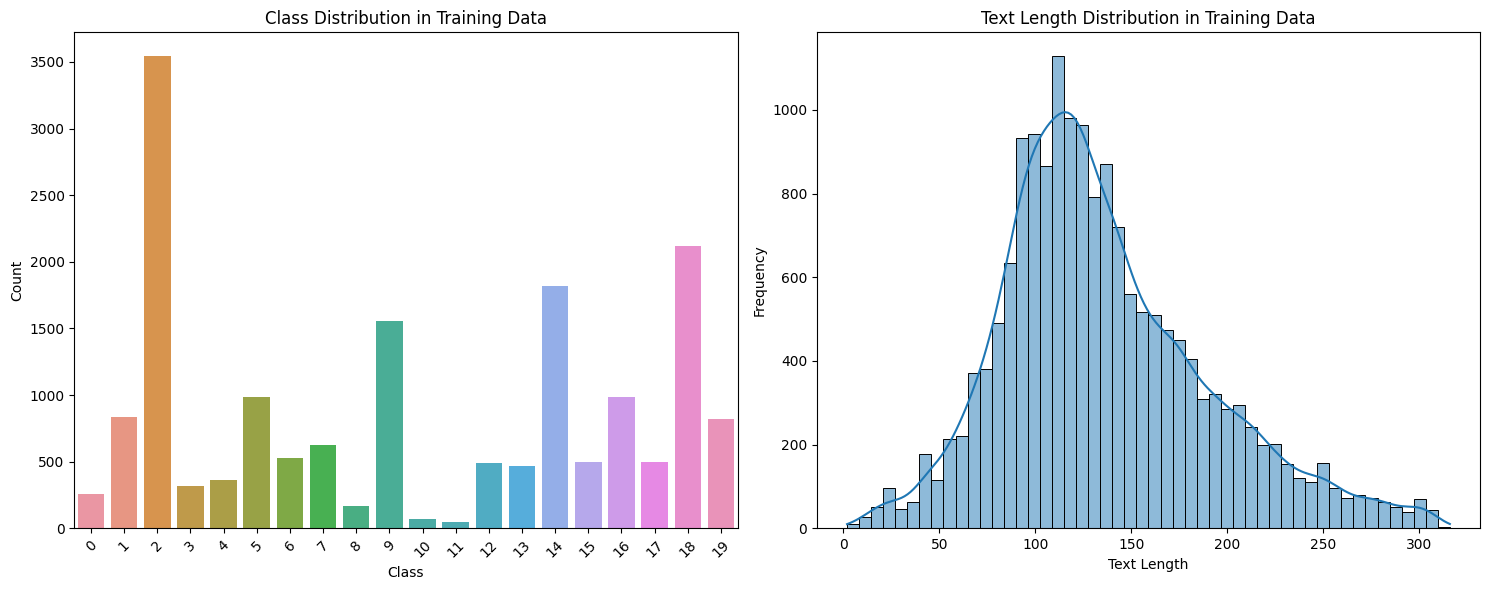

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Convert to Pandas DataFrame for class distribution analysis
train_df = pd.DataFrame(train_dataset)
validation_df = pd.DataFrame(validation_dataset)

# Basic data exploration
print("Number of training samples:", len(train_df))
print("Number of validation samples:", len(validation_df))

# Calculate average text length
train_df["text_length"] = train_df["text"].apply(len)
avg_text_length = train_df["text_length"].mean()
print("Average text length:", avg_text_length)

# Create subplots for class distribution and text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Class Distribution using Seaborn
sns.countplot(x="label", data=train_df, ax=axes[0])
axes[0].set_title("Class Distribution in Training Data")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Text Length Distribution using Seaborn
sns.histplot(train_df["text_length"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Text Length Distribution in Training Data")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
train = tf.data.Dataset.from_generator(
    lambda: train_dataset,  # Replace 'train' with your dataset split
    output_signature={
        'text': tf.TensorSpec(shape=(), dtype=tf.string),
        'label': tf.TensorSpec(shape=(), dtype=tf.int64),  # Adjust dtype as needed
    }
)

val = tf.data.Dataset.from_generator(
    lambda: validation_dataset,  # Replace 'train' with your dataset split
    output_signature={
        'text': tf.TensorSpec(shape=(), dtype=tf.string),
        'label': tf.TensorSpec(shape=(), dtype=tf.int64),  # Adjust dtype as needed
    }
)

def preprocess(el):
  return el['text'],el['label']

train_p = train.map(preprocess)
val_p = val.map(preprocess)

In [ ]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int64, name=None))>

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the tokenization function for TensorFlow
def tf_bert_tokenize(text, label):
    def tokenization_fn(text):
        # Tokenize the text
        inputs = tokenizer(text.numpy().decode('utf-8'), padding='max_length', truncation=True, max_length=max_sequence_length)
        return (inputs['input_ids'], inputs['attention_mask']), label

    # Wrap the Python function for use in the TensorFlow graph
    return tf.py_function(tokenization_fn, [text], (tf.int32, tf.int32, tf.int64))

# Apply the tokenization function to the datasets
train_dataset = train_p.map(tf_bert_tokenize)
val_dataset = val_p.map(tf_bert_tokenize)

# Define a function to pad sequences
def pad_sequences(data):
    inputs, label = data
    input_ids, attention_mask = inputs
    input_ids = tf.pad(input_ids, paddings=[[0, max_sequence_length - tf.shape(input_ids)[0]]])
    attention_mask = tf.pad(attention_mask, paddings=[[0, max_sequence_length - tf.shape(attention_mask)[0]]])

    return {'input_ids': input_ids, 'attention_mask': attention_mask}, label

# Apply the pad_sequences function to the datasets
train_dataset = train_dataset.map(pad_sequences)
val_dataset = val_dataset.map(pad_sequences)

# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

# Load Pre-trained Model Configuration
model_name = 'bert-base-uncased'
bert_model = TFBertForSequenceClassification.from_pretrained(model_name)

# Compile the BERT Model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the BERT Model
history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


TypeError: ignored

In [ ]:
for element in train_dataset.take(1):
    print(element)


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate the maximum sequence length in your dataset
max_sequence_length = max(
    max(len(tokenizer.encode(example['text'])) for example in train_dataset),
    max(len(tokenizer.encode(example['text'])) for example in validation_dataset)
)

print("Maximum Sequence Length:", max_sequence_length)

# Define your tokenization function within TensorFlow
def tf_bert_tokenize(text, label):
    def tokenization_fn(text):
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=max_sequence_length, return_tensors="tf")
        return inputs, label

    inputs, label = tf.py_function(tokenization_fn, [text], [tf.int32, tf.int32])
    inputs[0].set_shape([max_sequence_length])  # Set the shape for input_ids
    inputs[1].set_shape([max_sequence_length])  # Set the shape for attention_mask
    return inputs, label

# Apply the tokenization function to the datasets
train_dataset = train_p.map(tf_bert_tokenize)
val_dataset = val_p.map(tf_bert_tokenize)

Maximum Sequence Length: 147


In [ ]:
# Define the maximum sequence length
max_sequence_length = 147  # Replace with your desired sequence length

# Define a function to pad sequences
def pad_sequences(inputs, label):
    input_ids = tf.pad(inputs['input_ids'], paddings=[[0, max_sequence_length - tf.shape(inputs['input_ids'])[0]]])
    attention_mask = tf.pad(inputs['attention_mask'], paddings=[[0, max_sequence_length - tf.shape(inputs['attention_mask'])[0]]])
    return {'input_ids': input_ids, 'attention_mask': attention_mask}, label


train_dataset = train_dataset.map(lambda inputs, label: (pad_sequences(inputs, label)))
val_dataset = val_dataset.map(lambda inputs, label: (pad_sequences(inputs, label)))



# Batch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=20000)

# Load Pre-trained Model Configuration
model_name = 'bert-base-uncased'
bert_model = TFBertForSequenceClassification.from_pretrained(model_name)

# Compile the BERT Model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the BERT Model
history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


TypeError: ignored

In [ ]:
 %pip install tiktoken --quiet
import tiktoken

# Example text
text = "This is an example sentence."

# Initialize the tokenizer
enc = tiktoken.get_encoding('r50k_base')

# Tokenize the text
tokenized_text = enc.encode(text)

# Count tokens
token_count = len(tokenized_text)

# Print the tokens and token count
print("Tokenized Text:", tokenized_text)
print("Token Count:", token_count)

Tokenized Text: [1212, 318, 281, 1672, 6827, 13]
Token Count: 6


In [ ]:
enc.n_vocab

50257

In [ ]:
train = tf.data.Dataset.from_generator(
    lambda: train_dataset,  # Replace 'train' with your dataset split
    output_signature={
        'text': tf.TensorSpec(shape=(), dtype=tf.string),
        'label': tf.TensorSpec(shape=(), dtype=tf.int64),  # Adjust dtype as needed
    }
)

val = tf.data.Dataset.from_generator(
    lambda: validation_dataset,  # Replace 'train' with your dataset split
    output_signature={
        'text': tf.TensorSpec(shape=(), dtype=tf.string),
        'label': tf.TensorSpec(shape=(), dtype=tf.int64),  # Adjust dtype as needed
    }
)

In [ ]:
el = next(iter(train))

In [ ]:
def preprocess(el):
  return el['text'],el['label']

@tf.py_function(name = 'tokenize', Tout=(tf.int32,tf.int64))
def tokenize(text, label):
  text = text.numpy().decode('utf8')
  tokens = enc.encode(text)
  #we need to wrap into a tensor
  return tf.convert_to_tensor(tokens), label
         #list of integers, integers but different type, int.32 and 64

In [ ]:
train_p = train.map(preprocess).map(tokenize).cache()
val_p = val.map(preprocess).map(tokenize).cache()

In [ ]:
batch_size = 32
# Batch and pad the training dataset
train_p_batched = train_p.padded_batch(batch_size, padded_shapes=([None], []))
# Batch and pad the validation dataset
val_p_batched = val_p.padded_batch(batch_size, padded_shapes=([None], []))

train_p_batched = train_p_batched.shuffle(buffer_size=20000)

In [ ]:
# Take one batch from the dataset
for inputs, labels in train_p_batched.take(1):
    print("Inputs:", inputs)
    print("Labels:", labels)
    break


Inputs: tf.Tensor(
[[29353 17005  4953 ...    50    70 10188]
 [41551   324  1122 ...     0     0     0]
 [33813  3614 25579 ...     0     0     0]
 ...
 [   37 47314   753 ...     0     0     0]
 [ 4338  8890  1082 ...     0     0     0]
 [   50  1073 43813 ...     0     0     0]], shape=(32, 71), dtype=int32)
Labels: tf.Tensor(
[13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13], shape=(32,), dtype=int64)


In [ ]:
def map_to_dict(input_ids, labels):
    attention_mask = tf.cast(input_ids != 0, dtype=tf.int32)
    return {"input_ids": input_ids, "attention_mask": attention_mask}, labels

train_dataset = train_p_batched.map(map_to_dict)
val_dataset = val_p_batched.map(map_to_dict)


In [ ]:
for inputs, labels in train_dataset.take(1):
    print("Inputs:", inputs)
    print("Labels:", labels)
    break


In [ ]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, config, rank):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(rank, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(config.hidden_size, use_bias=False)

    def call(self, inputs):
        intermediate = self.dense1(inputs)
        output = self.dense2(intermediate)
        return inputs + output

class BertLoRAModel(TFBertForSequenceClassification):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.lora = LoRALayer(config, rank=32)

    def call(self, inputs, **kwargs):
        # Ensure inputs are in the correct format for the BERT layer
        bert_inputs = {key: inputs[key] for key in ['input_ids', 'attention_mask', 'token_type_ids'] if key in inputs}
        bert_outputs = self.bert(bert_inputs, **kwargs)

        # Apply LoRA to the last hidden state
        lora_output = self.lora(bert_outputs.last_hidden_state)

        # Use the classifier head of the model to get the final logits
        logits = self.classifier(lora_output)

        return logits

# Load Pre-trained Model Configuration
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name)

# Initialize LoRA BERT Model
lora_bert_model = BertLoRAModel(config)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lora_bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model (assuming train_dataset and val_dataset are already defined)
history = lora_bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


Epoch 1/3


AttributeError: ignored

In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertConfig

# Define the LoRA Layer
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, config, rank):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(rank, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(config.hidden_size, use_bias=False)

    def call(self, inputs):
        intermediate = self.dense1(inputs)
        output = self.dense2(intermediate)
        return inputs + output

# Subclass the BERT Model for Sequence Classification with LoRA
class BertLoRAModel(TFBertForSequenceClassification):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.lora = LoRALayer(config, rank=32)

    def call(self, inputs, **kwargs):
        # Retrieve outputs from the BERT layer
        bert_outputs = self.bert(inputs, **kwargs)

        # Apply LoRA to the sequence output (hidden states)
        lora_output = self.lora(bert_outputs.last_hidden_state)

        # Pass the modified output through the classifier
        logits = self.classifier(lora_output)

        return logits



# Load Pre-trained Model Configuration
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name)

# Initialize LoRA BERT Model
lora_bert_model = BertLoRAModel(config)

# Compile the LoRA-modified BERT Model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lora_bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the LoRA-modified BERT Model
history = lora_bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


ValueError: ignored

In [ ]:
from transformers import TFBertForSequenceClassification, BertConfig

model_name = 'bert-base-uncased'
bert_model = TFBertForSequenceClassification.from_pretrained(model_name)

class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, config, rank):
        super().__init__()
        self.rank = rank
        self.dense1 = tf.keras.layers.Dense(rank, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(config.hidden_size, use_bias=False)

    def call(self, inputs):
        # Low-rank adaptation
        intermediate = self.dense1(inputs)
        output = self.dense2(intermediate)
        return inputs + output  # Residual connection

class BertLoRAModel(TFBertModel):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        # Example: Adding LoRA to the first attention layer
        self.lora = LoRALayer(config, rank=32)  # Rank is a hyperparameter

    def call(self, inputs, **kwargs):
        outputs = super().call(inputs, **kwargs)

        # Apply LoRA to the output of the first attention layer
        lora_output = self.lora(outputs[0])

        # Ensure the output is in the format TensorFlow expects
        # For example, if you're doing classification, you might want to return logits
        return {'logits': lora_output}

# Loop over the layers of the original model
for layer in bert_model.layers:
    try:
        # Find the corresponding layer in the LoRA model and set weights
        lora_bert_model.get_layer(layer.name).set_weights(layer.get_weights())
    except ValueError:
        # Skip if the layers don't match (like LoRA layers)
        continue

for layer in lora_bert_model.layers:
    if not isinstance(layer, LoRALayer):
        layer.trainable = False

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

history = bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: ignored

In [ ]:
class LoRALayer(tf.keras.layers.Layer):
    def __init__(self, config, rank):
        super().__init__()
        self.dense1 = tf.keras.layers.Dense(rank, use_bias=False)
        self.dense2 = tf.keras.layers.Dense(config.hidden_size, use_bias=False)

    def call(self, inputs):
        intermediate = self.dense1(inputs)
        output = self.dense2(intermediate)
        return inputs + output  # Add the LoRA output to the original input
from transformers import TFBertForSequenceClassification

class BertLoRAModel(TFBertForSequenceClassification):
    def __init__(self, config, *inputs, **kwargs):
        super().__init__(config, *inputs, **kwargs)
        self.lora = LoRALayer(config, rank=32)  # Define the LoRA layer

    def call(self, inputs, **kwargs):
        # Call the original model
        outputs = super().call(inputs, **kwargs)

        # Apply LoRA to the last hidden state
        sequence_output = self.lora(outputs.last_hidden_state)

        # You might need to adjust this depending on how your model processes the output
        pooled_output = self.bert.pooler(sequence_output) if self.bert.pooler is not None else None

        # Forward pass through the classifier
        logits = self.classifier(pooled_output)

        return tf.keras.layers.Activation('softmax')(logits)  # Or another activation depending on your task
model_name = 'bert-base-uncased'
config = BertConfig.from_pretrained(model_name)
lora_bert_model = BertLoRAModel.from_pretrained(model_name, config=config)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
lora_bert_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = lora_bert_model.fit(train_dataset, validation_data=val_dataset, epochs=3)


In [ ]:
next(iter(train_p))

(<tf.Tensor: shape=(39,), dtype=int32, numpy=
 array([ 8586,   527,  7950,   596,  8706, 18738,  6880,    25,  8325,
           11,  8339,    11, 28298,    11, 11165,   519,   404,    11,
        22452,    84,  7412,    11, 77127,   612,  1141,    26,   810,
          220,  3788,  1129,    83,  6973, 46374, 18378,    23,    38,
        27515,    22, 72891], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=0>)

### Exercise 1: Advanced transfer learning (10 points)

For this exercise, you are asked to implement some form of "advanced" transfer learning method. These include, but are not limited to, the content of Lecture 10 in the course, e.g.:

1.   **Parameter-efficient fine-tuning** (PEFT) methods (LoRA, adapters, soft prompting, ...).
2.   **Task vectors** and arithmetic in the weight space.
3.   **Model merging** and model combination (e.g., relative representations).

The following are useful surveys and papers you can take inspiration from. If you are in doubt, ask me before starting.

1. [Scaling Down to Scale Up: A Guide to Parameter-Efficient Fine-Tuning](https://arxiv.org/abs/2303.15647) - A survey on PEFT models.
2. [Modular Deep Learning](https://arxiv.org/abs/2302.11529) - A tutorial on the emerging paradigm of modular deep learning, in which networks are composed of modular building blocks. This is connected to PEFT, see in particular Section 7.
3. Examples of model merging: [model ratatouille](https://arxiv.org/abs/2212.10445), [git re-basin](https://arxiv.org/abs/2209.04836), [Fisher averaging](https://arxiv.org/abs/2111.09832).
4. Examples of task arithmetic: [simple arithmetic](https://arxiv.org/abs/2212.04089), [tangent space](https://arxiv.org/abs/2305.12827).

For this exercise, you can either transfer from two models that you trained autonomously (e.g., train one model on another dataset, add an adapter, fine-tune on the dataset you selected before), or fine-tune directly from a pre-trained model found on the web. For finding pre-trained models, you can check [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications), [TensorFlow model garden](https://www.tensorflow.org/guide/model_garden?hl=it), or the [Hugging Face Hub](https://huggingface.co/docs/hub/index).

> 🟥 Remember that the homework must be done fully in TensorFlow, with no external libraries (when in doubt, ask).

✍ **DESCRIPTION OF THE CODE**

*Provide a description of what you are implementing, both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

In [ ]:
# TODO: Your code here.

### Exercise 2: Interpreting the results (5 points)

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 8/10). For a mark of 8/10 or higher, an additional point can also be recovered during the exam.**

> **To recap**: if you submitted the mid-term homework, implement only Exercise 1, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1 and 2 for a total of *15 points*.

[LIME](https://arxiv.org/abs/1602.04938) (**Local Interpretable Model-agnostic Explanations**) is a very common explainability method, which trains a small interpretable model (e.g., a linear model) around a prediction $f(x)$ to interpret the prediction. For this exercise:

1. Read carefully the original LIME paper.
2. Re-implement the LIME algorithm and test it on 1 or 2 predictions given by your neural network (from Exercise 1).
3. This must be done fully in TensorFlow (same as the previous exercise).
4. LIME requires to select how to represent the inputs (e.g., patches of the original image). Explain your choice below.
5. Analyze the results you obtain.

In [ ]:
# TODO: Implement and test LIME.

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

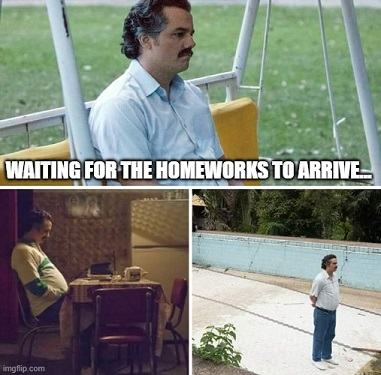